# Regression Models

Regression aims to estimate the world state $w$ for a given observations $\mathbf{x}$ by modeling $P(w|\mathbf{x})$ based on obtained data $\{\mathbf{x}_{i}, w_{i}\}_{i=1}^N$.

## Table of contents:
* [Maximum Likelihood Linear Regression](#ml-linear-regression)
* [Bayesian linear regression](#bayesian-linear-regression)
* [Non-linear regression - Maximum Likelihood](#non-linear-regression-ml)
* [Non-linear regression - Bayesian Inference](#non-linear-regression-bayes)
* [Kernels and Gaussian process regression](#kernel-gaussian-process-regression)
* [Sparse linear regression](#sparse-linear-regression)
* [Dual linear regression](#dual-linear-regression)
* [Relevance vector regression](#relevant-vector-regression)
* [Regression to multivariate data](#multivariate-data)

# Dual linear regression <a class="anchor" id="dual-linear-regression"></a>

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [332]:
def generate_nice_params(ns):
    """
    Arguments:
    
    Output:
        sg:   std of the gaussians.
        phi:  weight distribution of the gaussians.
        sgp:  prior std.
    """
    # sg = 1 x 1
    # sgp = 1 x 1
    # phi = D x 1
    sg = 2 * np.random.rand() + 0.5
    sgp = 0.05 * np.random.rand() + 0.01
    psi = np.random.normal(0, sgp, (ns, 1)) 
    return sg, sgp, psi


def plot_samples(x, w, phi, clr=(0.8, 0.4, 0.0), lwd=2):
    line_x = np.array([[1., 1.], [-10, 10]])
    plt.plot(x[1].squeeze(), w.squeeze(), 'b.', markersize=5.)
    plt.plot(line_x[1,:], np.dot(phi.T, line_x).squeeze(), ls='-', lw = lwd, color=clr) 

    
def plot_rg_pdf(phi, sg, nres):
    nn = nres**2
    res = np.linspace(-15, 15, nres)
    x, y = np.meshgrid(res, res)
    x_flat = x.reshape(1, nn)
    y_flat = y.reshape(1, nn)
    x1_flat = np.vstack((np.ones(nn), x_flat.squeeze()))
    mu_flat = np.dot(phi.T, x1_flat)
    rg_pdf = spst.norm.pdf(y_flat, mu_flat, sg*np.ones(nn)).reshape((nres, nres))
    rg_pdf = np.flipud(rg_pdf)
    plt.imshow(rg_pdf, extent=[-15, 15, -15, 15])
    return x1_flat, y_flat


def alt_inv(A, B, C, D):
    """
    Ainv - Ainv * B * (D + C * A * B)inv * C * Ainv = (A + B * Dinv * C)inv
    A^{-1} - A^{-1}B(D + CAB)^{-1}CA^{-1} = (A + BD^{-1}C)^{-1}
    Arguments: 
        A: (N, N)
        B: (N, D)
        C: (D, N)
        D: (D, D)
    
    Output:
        invm: (N, N)
    """
    Ainv = np.linalg.inv(A)
    AinvB = np.dot(Ainv, B)
    CAinv = np.dot(C, Ainv)
    mid = D
    mid += np.dot(np.dot(C, A), B)
    midinv = np.linalg.inv(mid)
    invm = Ainv - np.dot(np.dot(AinvB, midinv), CAinv)
    return invm


def bayesian_inference(xs, x, w, sg, sgp):
    """
    Arguments:
        zs:    z star. (ng+1 x nres**2) D x N*
        z:     bases_smp. z coodinates of the samp. (ng+1 x ns)
        w:     smp. sampled from grdtr added with sg noise, (ns, )
        sgp:   scalar. prior std.
        sg:    sg candidates. (100, )
    
    Output:
        cinv:  inverse of C (ng+1 x ng+1)
        
    """
    # w = N x 1
    # x = D x N
    # xs = D x N*
    # A = N x N
    # mu = N* x 1
    # cov = N* x 1
    D = x.shape[0]
    N = x.shape[1]
    sgs = sg**2
    sgps = sgp**2
    
    xt_x = np.dot(x.T, x)
    A = np.dot(xt_x, xt_x)/sgs + np.eye(N)/sgps
    A_inv = np.linalg.inv(A)
    xst_x = np.dot(xs.T, x)
    xt_x_w = np.dot(xt_x, w)
    
    xst_x_A_inv = np.dot(xst_x, A_inv)
    sgm = (xst_x_A_inv * xst_x).sum(axis=1) + sg
    mu = np.dot(xst_x_A_inv, xt_x_w) / sgs
    return mu, np.sqrt(sgm)



(-10, 10)

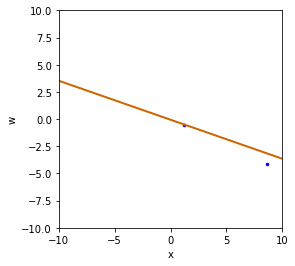

In [336]:
ns = 2
nres = 151
x_range = np.array([-10., 10.])
sg, sgp, psi = generate_nice_params(ns)
x = (x_range[1] - x_range[0]) * np.random.rand(ns) + x_range[0]
x1 = np.vstack((np.ones(ns), x))
phi = np.dot(x1, psi)
w = np.dot(x1.T, phi) + np.random.normal(0, sg, (ns, 1))

plt.rcParams['figure.figsize'] = (4.0, 4.0)
plot_samples(x1, w, phi)
plt.xlabel("x")
plt.ylabel("w")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

(-10, 10)

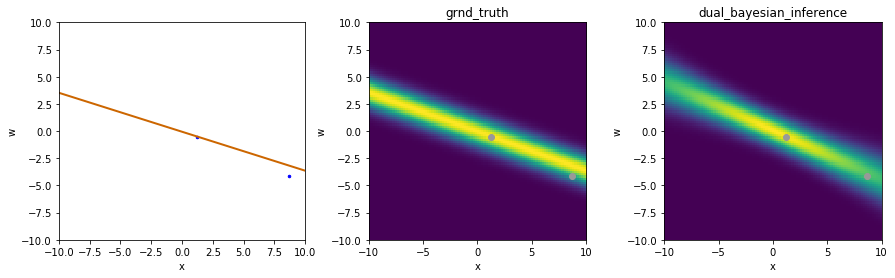

In [337]:
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1,3,1)
plot_samples(x1, w, phi)
plt.xlabel("x")
plt.ylabel("w")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(1,3,2)
x1s, ys = plot_rg_pdf(phi, sg, nres)
plt.scatter(x.squeeze(), w.squeeze(), color=(0.6, 0.6, 0.6))
plt.title("grnd_truth")
plt.xlabel("x")
plt.ylabel("w")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(1,3,3)
mu, sgm = bayesian_inference(x1s, x1, w, sg, sgp)
rg_pdf = spst.norm.pdf(ys.squeeze(), mu.squeeze(), sgm.squeeze()).reshape((nres, nres))
rg_pdf = np.fliplr(rg_pdf)
plt.imshow(rg_pdf, extent=[-15, 15, -15, 15])
plt.scatter(x.squeeze(), w.squeeze(), color=(0.6, 0.6, 0.6))
plt.title("dual_bayesian_inference")
plt.xlabel("x")
plt.ylabel("w")
plt.xlim(-10, 10)
plt.ylim(-10, 10)



In [338]:
def generate_nice_params():
    """
    Arguments:
    
    Output:
        sg:   std of the gaussians.
        phi:  weight distribution of the gaussians.
        sgp:  prior std.
    """
    # sg = 1 x 1
    # sgp = 1 x 1
    # phi = D x 1
    sg = 2 * np.random.rand() + 0.5
    sgp = 100 * np.random.rand()
    phi1 = 3 * (np.random.rand() - .5)
    phi0 = 2 * (np.random.rand() - .5)
    phi = np.vstack((phi0, phi1))
    return sg, phi, sgp

def generate_samples(x_range, sg, phi, ns):
    # w = 1 x N
    # x = D x N
    # phi = D x 1
    # mid = N x N
    # cinv = D x D
    x = np.random.rand(ns)
    x *= (x_range[1] - x_range[0])
    x += x_range[0]
    x = np.vstack((np.ones(ns), x))
    w  = np.dot(phi.T, x)
    w += np.random.randn(ns) * sg
    w = w.T
    return x, w

def plot_samples(x, w, phi, clr=(0.8, 0.4, 0.0), lwd=2):
    line_x = np.array([[1., 1.], [-10, 10]])
    plt.plot(x[1], w.squeeze(), 'b.', markersize=5.)
    plt.plot(line_x[1], np.dot(phi.T, line_x).squeeze(), ls='-', lw = lwd, color=clr) 

def plot_rg_pdf(phi, sg, n):
    nn = n**2
    res = np.linspace(-20, 20, n)
    x, y = np.meshgrid(res, res)
    x_flat = x.reshape(1, nn)
    y_flat = y.reshape(1, nn)
    x1_flat = np.vstack((np.ones(nn), x_flat.squeeze()))
    mu_flat = np.dot(phi.T, x1_flat)
    rg_pdf = spst.norm.pdf(y_flat, mu_flat, sg*np.ones(nn)).reshape((n, n))
    rg_pdf = np.flipud(rg_pdf)
    plt.imshow(rg_pdf, extent=[-15, 15, -15, 15])
    
def Cinv(x, w, sg, sgp):
    # w = N x 1
    # x = D x N
    # mid = N x N
    # cinv = D x D
    D = x.shape[0]
    N = x.shape[1]
    sgs = sg**2
    sgps = sgp**2
    mid = np.dot(x.T, x)
    mid += (sgs / sgps) * np.eye(N)
    midinv = np.linalg.inv(mid)
    cinv = np.eye(D)
    cinv -= np.dot(np.dot(x, midinv), x.T)
    cinv *= sgps
    return cinv

def bayesian_inference(xs1, x, w, sg, sgp):
    # w = N x 1
    # x = D x N
    # xs1 = D x N*
    # phi = D x 1
    # cinv = D x D
    # mu = N* x 1
    # cov = N* x 1
    D = x.shape[0]
    N = x.shape[1]
    sgs = sg**2
    sgps = sgp**2
    xt_x = np.dot(x.T, x)
    A = np.dot(xt_x, xt_x)/sgs + np.eye(N)/sgps
    A_inv = np.linalg.inv(A)
    cinv = np.dot(np.dot(x, A_inv), x.T)
    phi = np.dot(np.dot(cinv, x), w) / sgs
    mu = np.dot(xs1.T, phi).squeeze()
    # doing double np.dot then taking np.diag would be costly. instead we do this.
    cov = (np.dot(cinv, xs1) * xs1).sum(axis=0)
    cov += sgs
    cov = np.sqrt(cov)
    return mu, cov, phi, cinv

def generate_phi_pdf(phimu, phisg, nres, bb):
    res = np.linspace(-bb, bb, nres)
    p0g, p1g = np.meshgrid(res, res)
    p0s = p0g.reshape(1, nres ** 2)
    p1s = p1g.reshape(1, nres ** 2)
    ps = np.vstack((p0s, p1s))
    phi_pdf = spst.multivariate_normal.pdf(ps.T, mean=phimu, cov=phisg).reshape((nres, nres))
    return phi_pdf

def evaluate_sigma(x, w, sgp, sg):
    # w = N x 1
    # x = D x N
    # sg = S x 1
    sgs = sg**2
    sgps = sgp**2
    sg_eval = np.zeros(sg.shape[0])
    xsgs_cache = sgps * np.dot(x.T, x)
    for i in range(sg.shape[0]):
        xsgs = xsgs_cache + sgs[i] * np.eye(x.shape[1])
        xsgsinv = np.linalg.inv(xsgs)
        sg_eval[i] = (np.dot(xsgsinv, w) * w).sum()
        sg_eval[i] += np.log(np.linalg.det(xsgs))
        #wpdf = spst.multivariate_normal.pdf(w.squeeze(), mean=np.zeros(x.shape[1]), cov=xsgs)
        #sg_eval[i] = np.log(wpdf)
    return sg_eval
    



rough scan :  1.3
 fine scan :  1.31
true  : sg = 0.6773 
infer : sg = 1.3100


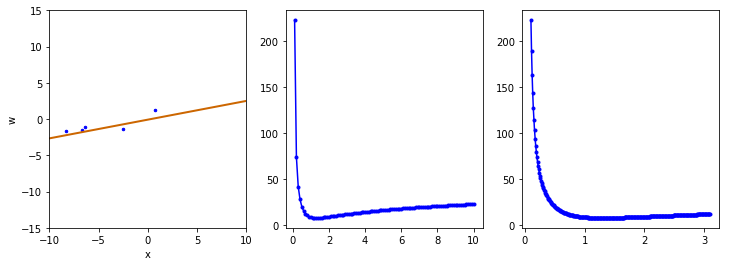

In [328]:
ns = 5
x_range = np.array([-10., 10.])
sg, phi, sgp = generate_nice_params()
x, w = generate_samples(x_range, sg, phi, ns)

ns = 5
nres = 151
x_range = np.array([-10., 10.])
sg = 2 * np.random.rand() + 0.5
sgp = 0.05 * np.random.rand() + 0.01
psi = np.random.normal(0, sgp, (ns, 1))
x = (x_range[1] - x_range[0]) * np.random.rand(ns) + x_range[0]
x1 = np.vstack((np.ones(ns), x))
phi = np.dot(x1, psi)
w = np.dot(x1.T, phi) + np.random.normal(0, sg, (ns, 1))
x = x1

plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.subplot(1,3,1)
plot_samples(x, w, phi)
plt.xlim(x_range)
plt.ylim(1.5*x_range)
plt.xlabel("x")
plt.ylabel("w")

s1 = 0.1
s2 = 10.0
sg_candid = np.linspace(s1, s2, 100)
sg_eval = evaluate_sigma(x, w, sgp, sg_candid)
plt.subplot(1,3,2)
plt.plot(sg_candid, sg_eval, 'b.-')

idx = np.where(sg_eval == sg_eval.min())[0][0]
sg_inf = sg_candid[idx]
print('rough scan : ', sg_inf)

s1 = 0.1
s2 = 3.1
plt.subplot(1,3,3)
sg_candid = np.linspace(s1, s2, 301)
sg_eval = evaluate_sigma(x, w, sgp, sg_candid)
plt.plot(sg_candid, sg_eval, 'b.-')

idx = np.where(sg_eval == sg_eval.min())[0][0]
sg_inf = sg_candid[idx]
print(' fine scan : ', sg_inf)

print("true  : sg = {0:1.4f} \ninfer : sg = {1:1.4f}".format(sg, sg_inf))
sge = sg_inf

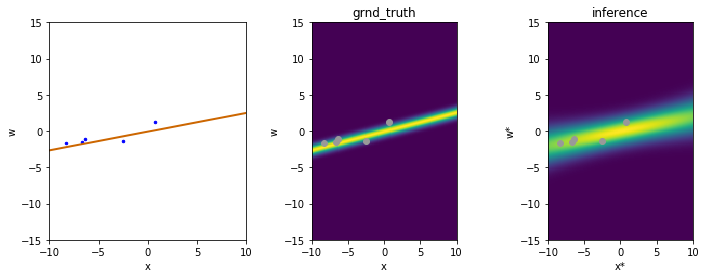

In [329]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)

plt.subplot(1,3,1)
plot_samples(x, w, phi)
plt.xlim(x_range)
plt.ylim(1.5*x_range)
plt.xlabel("x")
plt.ylabel("w")

nres = 201
plt.subplot(1,3,2)
plot_rg_pdf(phi, sg, nres)
plt.scatter(x[1].squeeze(), w.squeeze(), color=(0.6, 0.6, 0.6))
plt.xlim(x_range)
plt.ylim(1.5*x_range)
plt.title("grnd_truth")
plt.xlabel("x")
plt.ylabel("w")

res = np.linspace(-15, 15, nres)
xg, yg = np.meshgrid(res, res)
xs = xg.reshape(1, nres ** 2)
ys = yg.reshape(1, nres ** 2)
xs1 = np.vstack((np.ones(xs.shape[1]), xs))
mu, cov, phi, cinv = bayesian_inference(xs1, x, w, sge, sgp)
brg_pdf = spst.norm(mu, cov).pdf(ys.squeeze()).reshape((nres, nres))

plt.subplot(1,3,3)
rg_pdf = np.flipud(brg_pdf)
plt.imshow(rg_pdf, extent=[-15, 15, -15, 15])
plt.scatter(x[1].squeeze(), w.squeeze(), color=(0.6, 0.6, 0.6))
plt.xlim(x_range)
plt.ylim(1.5*x_range)
plt.title("inference")
plt.xlabel("x*")
plt.ylabel("w*")



In [309]:
x.shape

(2, 5)

In [310]:
w.shape

(5, 1)

In [312]:
phi.shape

(2, 1)